In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [2]:
path = tf.keras.utils.get_file('sunspots.csv', 
                               '  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv')
print (path)

C:\Users\Amir\.keras\datasets\sunspots.csv


<AxesSubplot:xlabel='Date'>

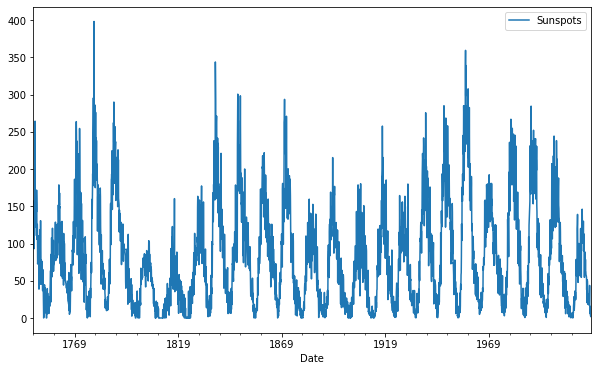

In [3]:
df = pd.read_csv(path, index_col='Date', parse_dates=True)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.columns = ['Sunspots']   # reaname column
df.plot(figsize=(10,6))

In [4]:
df.head()

,Sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [5]:
print('Total months data: ' + str(len(df)) + ' years:' + str(len(df)//12))

Total months data: 3235 years:269


In [6]:
split_time = 3000

train = df[:split_time]
test = df[split_time:]

print('Total test months: ' + str(len(test)) + ' train months: ' + str(len(train)))
print('Total test years: ' + str(len(test)//12) + ' train years: ' + str(len(train)//12))

Total test months: 235 train months: 3000
Total test years: 19 train years: 250


In [7]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [8]:
# 60 months = 5 years data for the the time window size
n_input = 60
n_features = 1
n_batch_size = 256

In [9]:
train_generator = TimeseriesGenerator(train, 
                                train, 
                                length = n_input, 
                                batch_size = n_batch_size)

In [10]:
x, y = train_generator[1]
print(x.shape)
print(y.shape)

(256, 60, 1)
(256, 1)


In [44]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape = (n_input,n_features)))
model.add(LSTM(60))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

In [45]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [46]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

In [47]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 60)            14880     
_________________________________________________________________
lstm_9 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_11 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 46,071
Trainable params: 46,071
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model.fit(train_generator, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 2s 167ms/step - loss: 0.0420 - mae: 0.2250
Epoch 2/100
12/12 [==============================] - 2s 170ms/step - loss: 0.0420 - mae: 0.2250
Epoch 3/100
12/12 [==============================] - 2s 171ms/step - loss: 0.0420 - mae: 0.2250
Epoch 4/100
12/12 [==============================] - 2s 172ms/step - loss: 0.0420 - mae: 0.2250
Epoch 5/100
12/12 [==============================] - 2s 154ms/step - loss: 0.0420 - mae: 0.2250
Epoch 6/100
12/12 [==============================] - 2s 155ms/step - loss: 0.0420 - mae: 0.2250
Epoch 7/100
12/12 [==============================] - 2s 204ms/step - loss: 0.0420 - mae: 0.2250
Epoch 8/100
12/12 [==============================] - 3s 230ms/step - loss: 0.0420 - mae: 0.2250
Epoch 9/100
12/12 [==============================] - 2s 194ms/step - loss: 0.0420 - mae: 0.2250
Epoch 10/100
12/12 [==============================] - 2s 164ms/step - loss: 0.0420 - mae: 0.2250
Epoch 11/100
12/12 [===================

In [51]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))   # stepping stone value

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0])                # predict and save in list
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1) # next value for prediction

In [52]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, 
                          columns=['Prediction'])

In [53]:
df_predict.head(2)

,Prediction
Date,
2013-08-31,73.005103
2013-09-30,73.338799


In [54]:
df_test = pd.concat([df,df_predict], axis=1)

In [55]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])) #error acceptable?

46.39971305844664

In [56]:
#df_test.plot(figsize=(14,6))

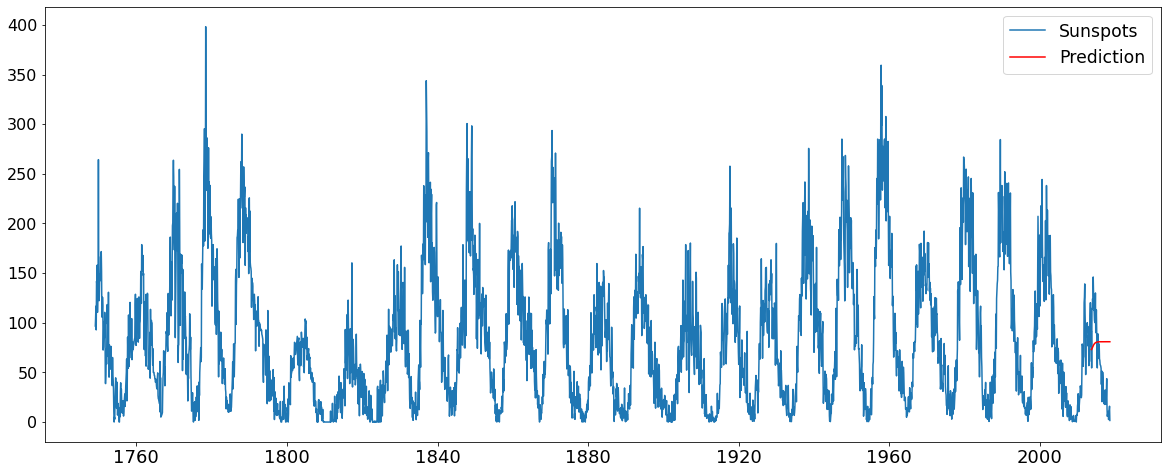

In [57]:
plt.figure(figsize=(20, 8))
plt.plot(df_test.index, df_test['Sunspots'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(["Sunspots", "Prediction"], loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [58]:
# This time train is using the full df for the future forecasting
train = df
len(train)

scaler.fit(train)
train = scaler.transform(train)

generator = TimeseriesGenerator(train, 
                                train, 
                                length = n_input, 
                                batch_size = n_batch_size)

In [59]:
model.fit(generator,epochs=100)

Epoch 1/10
13/13 [==============================] - 2s 178ms/step - loss: 0.0121 - mae: 0.1255
Epoch 2/10
13/13 [==============================] - 2s 161ms/step - loss: 0.0120 - mae: 0.1246
Epoch 3/10
13/13 [==============================] - 2s 153ms/step - loss: 0.0119 - mae: 0.1237
Epoch 4/10
13/13 [==============================] - 2s 163ms/step - loss: 0.0118 - mae: 0.1231
Epoch 5/10
13/13 [==============================] - 2s 153ms/step - loss: 0.0117 - mae: 0.1231
Epoch 6/10
13/13 [==============================] - 2s 175ms/step - loss: 0.0117 - mae: 0.1233
Epoch 7/10
13/13 [==============================] - 2s 176ms/step - loss: 0.0116 - mae: 0.1229
Epoch 8/10
13/13 [==============================] - 2s 177ms/step - loss: 0.0115 - mae: 0.1223
Epoch 9/10
13/13 [==============================] - 2s 185ms/step - loss: 0.0115 - mae: 0.1220
Epoch 10/10
13/13 [==============================] - 2s 155ms/step - loss: 0.0114 - mae: 0.1220


In [60]:
pred_list = []
n_future_length = 60   # 60 months
batch = train[-n_input:].reshape((1, n_input, n_features))
#n_future_length = len(train)   # 24 months
#batch = train[0:n_input].reshape((1, n_input, n_features))

for i in range(n_future_length):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [61]:
from pandas.tseries.offsets import DateOffset

add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0, n_future_length + 1) ]
future_dates = pd.DataFrame(index = add_dates[1:],
                            columns = df.columns)
len(future_dates)

60

In [62]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_future_length:].index, 
                          columns=['Prediction'])

In [63]:
df_projected = pd.concat([df,df_predict], axis=1)

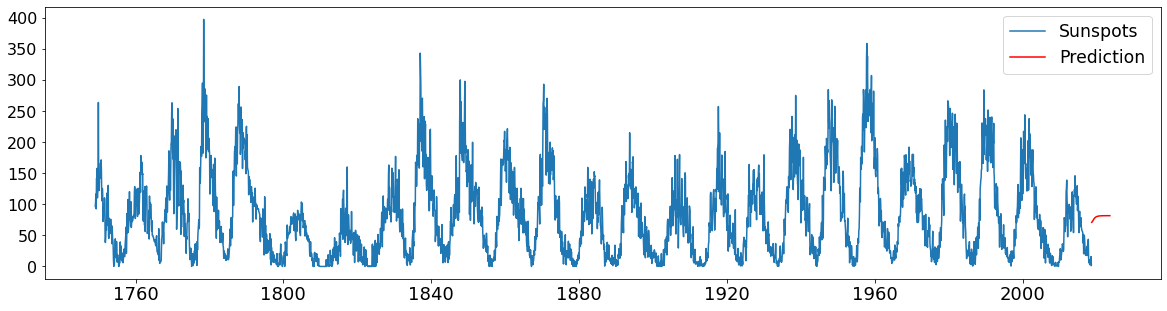

In [64]:
plt.figure(figsize=(20, 5))
plt.plot(df_projected.index, df_projected['Sunspots'])
plt.plot(df_projected.index, df_projected['Prediction'], color='r')
plt.legend(["Sunspots", "Prediction"], loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()